In [1]:
from dataclasses import dataclass
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

@dataclass
class IngestDataFromTlc:
    year: int = None
    month: str = None
    colour: str = None
    data: pd.DataFrame = None


    def read_taxi_data_from_tlc(self, year, month, colour) -> pd.DataFrame:
        """Downloads data from nyc taxi website and returns a pandas dataframe"""
        dataset_file = f"tripdata_{year}-{month}"
        dataset_url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{colour}_{dataset_file}.parquet"
        self.data = pd.read_parquet(dataset_url)
   
    

    # Create target varuable
    def create_target_variable(self):
        self.data["trip_duration"] = self.data["tpep_dropoff_datetime"] - self.data["tpep_pickup_datetime"]
        self.data["trip_duration"] = self.data["trip_duration"].dt.total_seconds()

    
    def impute_missing_values(self):
        cols = ["passenger_count"]
        for col in cols:
            self.data[col] = self.data[col].fillna(self.data[col].median())
     
    
    def remove_outliers(self):
        self.data = self.data[(self.data["trip_duration"] < 10000) & (self.data["trip_duration"] > 0)]
    
   

In [2]:
ingest = IngestDataFromTlc()
ingest.read_taxi_data_from_tlc(2019, "01", "yellow")
ingest.create_target_variable()
ingest.impute_missing_values()
ingest.remove_outliers()

In [3]:
class TransformRegressionTargets:
    def __init__(self, data):
        self.data = ingest.data
     
    # def viz_target_variable(self):
    #     self.data["trip_duration"].hist(bins=100)
    #     plt.show()

    def viz_target_variable(self):
        f, (ax0, ax1) = plt.subplots(1, 2)
        ax0.hist(ingest.data['trip_duration'], bins=100, density=True)
        ax0.set_xlim([0, 10000])
        ax0.set_ylabel("Probability")
        ax0.set_xlabel("Target")
        ax0.set_title("Target distribution")

        ax1.hist(self.data['trip_duration_log'], bins=100, density=True)
        ax1.set_ylabel("Probability")
        ax1.set_xlabel("Target")
        ax1.set_title("Transformed target distribution")

        plt.tight_layout()

    def viz_target_variable_plotly(self):
        fig = px.histogram(ingest.data, x="trip_duration", nbins=100, histnorm='probability density')
        fig.update_layout(title_text='Target distribution')
        fig.update_xaxes(title_text='Target')
        fig.update_yaxes(title_text='Probability')
        fig.show()

        fig = px.histogram(self.data, x="trip_duration_log", nbins=100, histnorm='probability density')
        fig.update_layout(title_text='Transformed target distribution')
        fig.update_xaxes(title_text='Target')
        fig.update_yaxes(title_text='Probability')
        fig.show()


    def log_transform_target_variable(self):
        self.data["trip_duration_log"] = np.log1p(self.data["trip_duration"])

   

In [4]:
transform = TransformRegressionTargets(ingest.data)

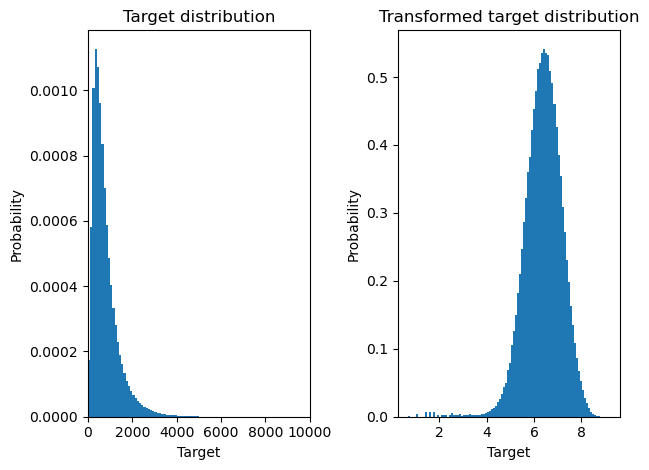

In [5]:

transform.log_transform_target_variable()
transform.viz_target_variable()


In [8]:
class Models:
    def __init__(self, data):
        self.data = ingest.data

    def split_data(self):
        X = self.data[["passenger_count", "trip_distance"]]
        y = self.data["trip_duration_log"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   

    def compute_score(y_true, y_pred):
        return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "Median absolute error": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

    def fit_linear_regression(self):
        X = self.data[["passenger_count"]]
        y = self.data["trip_duration_log"]
        model = LinearRegression()
        y_pred = cross_val_predict(model, X, y, cv=10)
        print(f"Median absolute error: {median_absolute_error(y, y_pred)}")
        print(f"R2 score: {r2_score(y, y_pred)}")

  

In [9]:
models = Models(ingest.data)
models.fit_linear_regression()

Median absolute error: 0.5005767567890986
R2 score: -0.001048644734114479


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt

X_db = ingest.data[["passenger_count", "total_amount"]]


y_db = ingest.data[['trip_duration']]
linear = LinearRegression()
y_pred = cross_val_predict(linear, X_db, y_db, cv=5)

c:\Users\rhys-\anaconda3\envs\loll\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:307: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


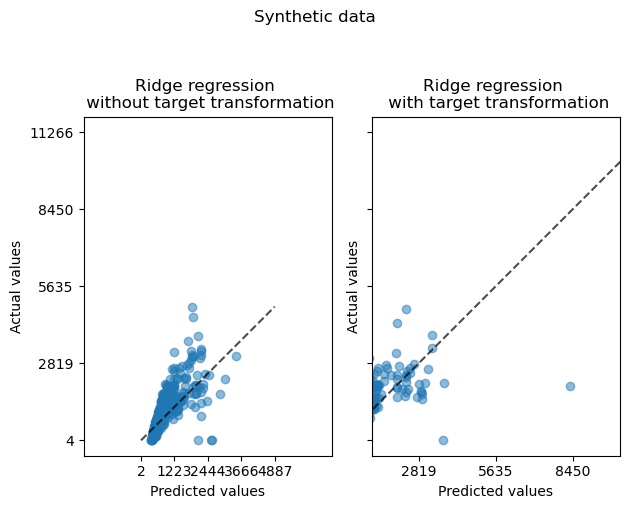

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay



f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)


ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
plt.tight_layout()

In [ ]:
linear_regression = LinearRegression().fit(X_train, y_train)
y_pred_linear_regression = linear_regression.predict(X_test)

linear_regression_with_trans_target = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1).fit(X_train, y_train)
y_pred_linear_regression_with_trans_target = linear_regression_with_trans_target.predict(X_test)

c:\Users\rhys-\anaconda3\envs\loll\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:307: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


In [10]:
def split_data():
        X = ingest.data[["passenger_count", "trip_distance"]]
        y = ingest.data["trip_duration_log"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

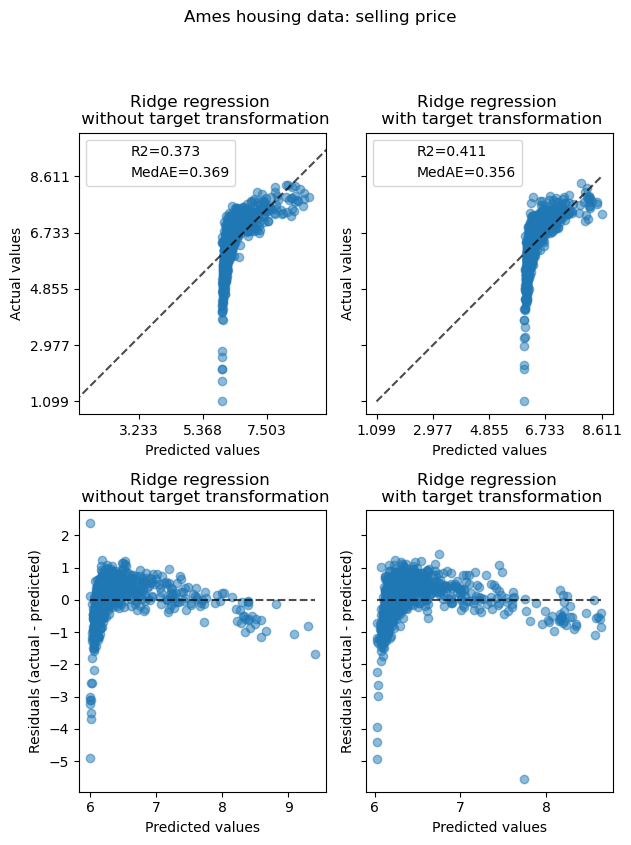

In [14]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import median_absolute_error, r2_score
X = ingest.data[["passenger_count", "trip_distance"]]
y = ingest.data["trip_duration_log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1]], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0[0].set_title("Ridge regression \n without target transformation")
ax0[1].set_title("Ridge regression \n with target transformation")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("Ridge regression \n without target transformation")
ax1[1].set_title("Ridge regression \n with target transformation")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()
plt.show()